<a href="https://colab.research.google.com/github/ZerXXX0/CV-handwring-recognition-for-digit/blob/main/MNIST_USPS_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Used for unpickling byte stream of python objects on file system/disk
import pickle
# Used for decompressing .gzip files from file system/disk
import gzip
# Used for array operations
import numpy as np

Loading MNIST Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Opening and decompressing .gzip file
filename = '/content/drive/MyDrive/Colab Notebooks/dataset/mnist.pkl.gz'
f = gzip.open(filename, 'rb')

# Unpickling .pkl file saved as byte stream on disk to python objects
trainingData, validationData, testingData = pickle.load(f, encoding='latin1')
f.close()

# Training feature vectors and training target extracted from trainingData (target represented using one-hot format)
trainingTarget = np.array([1 if  trainingData[1][i] == t else 0  for i in range(len(trainingData[1])) for t in range(10)]).reshape(-1,10)
trainingData = trainingData[0]

# Validation feature vectors and validation target extracted from validationData
validationTarget = validationData[1]
validationData = validationData[0]

# Testing feature vectors and testing target extracted from testingData
testingTarget = testingData[1]
testingData = testingData[0]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading USPS Dataset

In [4]:
# Used to open image in file system/disk
from PIL import Image
# Used to navigate to required directory in the file system
import os
# Used to convert image data to array
import numpy as np

In [5]:
USPSMat  = []
USPSTar  = []
curPath  = '/content/drive/MyDrive/Colab Notebooks/dataset/USPSdata/USPSdata/Numerals'
savedImg = []


# Navigate to the 10 folders containing images for 10 labels
for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':

            # Open image resize it, and save image array as well as labels in 2 lists
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

Neural Networks

In [7]:
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

#DNN
num_classes = len(trainingTarget[0])
DNNclassifier = Sequential()
DNNclassifier.add(Dense(units=200, activation='relu', input_shape=(len(trainingData[0]),)))
DNNclassifier.add(Dropout(0.2))
DNNclassifier.add(Dense(units=200, activation='relu'))
DNNclassifier.add(Dropout(0.2))
# DNNclassifier.add(Dense(units=200, activation='relu'))
# DNNclassifier.add(Dropout(0.2))
DNNclassifier.add(Dense(units=num_classes, activation='softmax'))
DNNclassifier.compile(optimizer='Adamax', loss='categorical_crossentropy',metrics=['accuracy'])
history = DNNclassifier.fit(trainingData, trainingTarget, batch_size=128, epochs=100,
verbose=False,validation_data=(validationData, keras.utils.to_categorical(validationTarget, num_classes)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
from sklearn.metrics import confusion_matrix

loss,valAccuracy = DNNclassifier.evaluate(validationData, keras.utils.to_categorical(validationTarget, num_classes), verbose=False)
loss,testAccuracy = DNNclassifier.evaluate(testingData, keras.utils.to_categorical(testingTarget, num_classes), verbose=False)
loss,testUSPSAccuracy = DNNclassifier.evaluate(np.array(USPSMat), keras.utils.to_categorical(USPSTar, num_classes), verbose=False)
dnnMNISTPrediction = np.argmax(DNNclassifier.predict(testingData), axis=1)
dnnUSPSPrediction = np.argmax(DNNclassifier.predict(np.array(USPSMat)), axis=1)

print ('---------------DNN----------------\n')
print('Validation accuracy    = ', valAccuracy*100)
print('MNIST Testing accuracy = ', testAccuracy*100)
print('USPS Testing accuracy  = ', testUSPSAccuracy*100,'"\n"')
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(testingTarget, dnnMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(USPSTar, dnnUSPSPrediction))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
---------------DNN----------------

Validation accuracy    =  98.4000027179718
MNIST Testing accuracy =  98.35000038146973
USPS Testing accuracy  =  51.82372331619263 "
"

MNIST Confusion Matrix: 

 [[ 973    0    1    1    0    1    1    1    2    0]
 [   0 1127    2    1    0    0    2    1    2    0]
 [   2    0 1017    1    2    0    1    7    2    0]
 [   0    0    4  990    0    5    0    7    1    3]
 [   0    0    2    0  964    0    4    0    2   10]
 [   3    0    0    5    1  874    5    1    2    1]
 [   4    2    1    1    3    2  942    0    3    0]
 [   1    3    9    1    1    0    0 1008    2    3]
 [   1    1    3    4    4    2    1    4  950    4]
 [   0    2    0    3    7    2    1    4    0  990]]

USPS Confusion Matrix: 

 [[ 544    1  325   72  176  134  168  192   93  295]
 [  35  452  506  111  177   79   17  518   72   33]
 [  38    2 1673   44    9   63   80   51   39    0]
 [

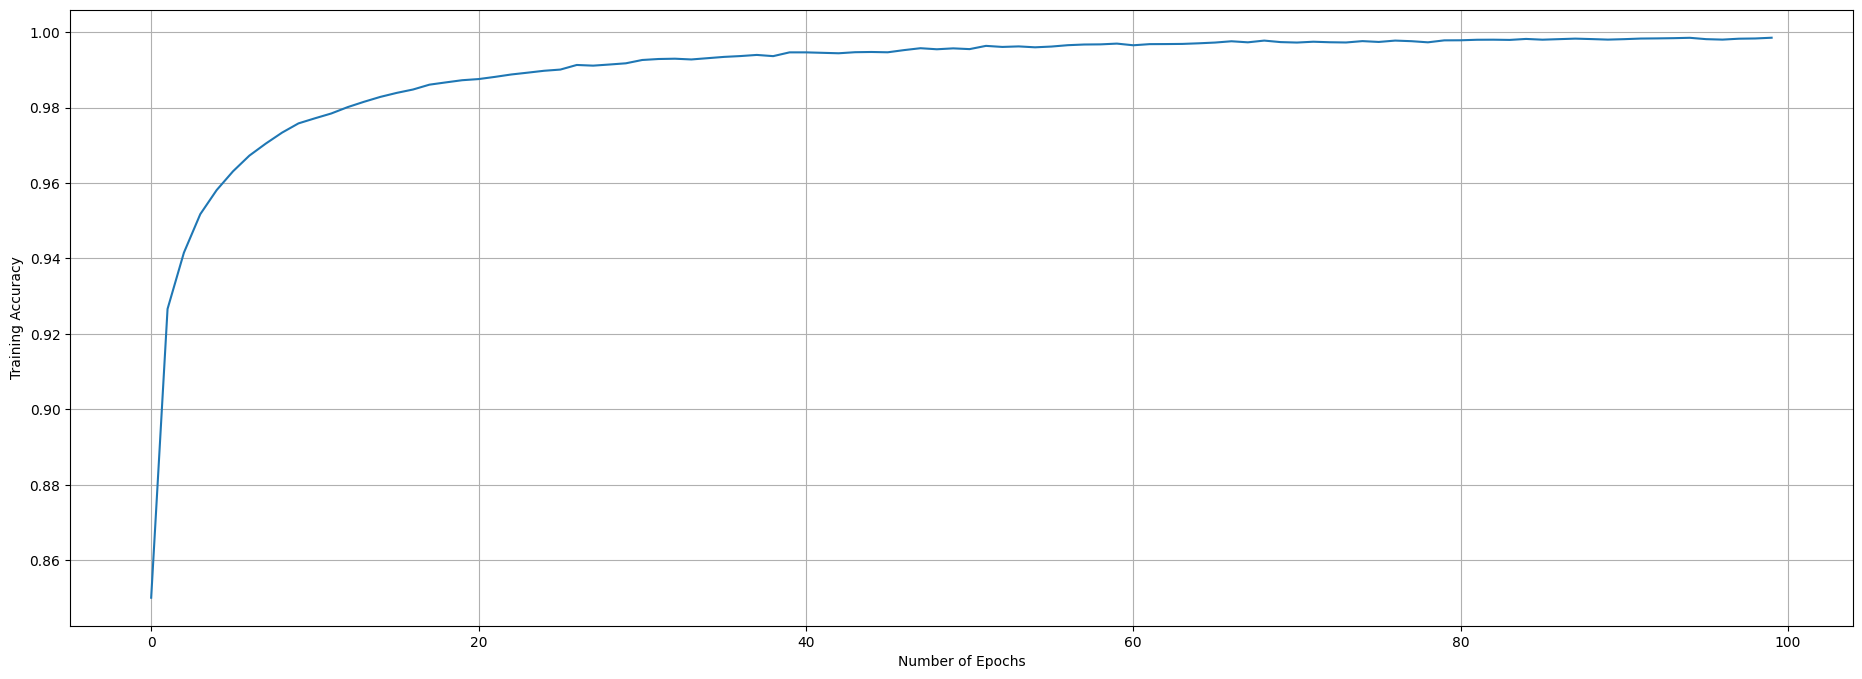

In [12]:
# The matplotlib package is used for plotting graphs
import matplotlib
import matplotlib.pyplot as plt
# Outputs training accuracy and loss against epochs
fig2, ax2=plt.subplots(figsize=(23,8))
ax2.plot(history.history['accuracy'])
ax2.set(xlabel='Number of Epochs', ylabel='Training Accuracy')
ax2.grid()
plt.show()

In [17]:
#CNN
CNNclassifier = Sequential()
CNNclassifier.add(Conv2D(20, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
CNNclassifier.add(MaxPooling2D(pool_size=(2, 2)))
CNNclassifier.add(Conv2D(20, (3, 3), activation='relu'))
CNNclassifier.add(MaxPooling2D(pool_size=(2, 2)))
CNNclassifier.add(Flatten())
CNNclassifier.add(Dense(units=200, activation='relu'))
CNNclassifier.add(Dropout(0.2))
CNNclassifier.add(Dense(units=200, activation='relu'))
CNNclassifier.add(Dropout(0.2))
CNNclassifier.add(Dense(units=num_classes, activation='softmax'))
CNNclassifier.compile(optimizer='Adamax', loss='categorical_crossentropy',metrics=['accuracy'])
history = CNNclassifier.fit(trainingData.reshape(-1, 28, 28, 1), trainingTarget, batch_size=128, epochs=100,
verbose=True,validation_data=(validationData.reshape(-1, 28, 28, 1), keras.utils.to_categorical(validationTarget, num_classes)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6929 - loss: 0.9709 - val_accuracy: 0.9572 - val_loss: 0.1479
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9442 - loss: 0.1826 - val_accuracy: 0.9736 - val_loss: 0.0906
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9613 - loss: 0.1227 - val_accuracy: 0.9805 - val_loss: 0.0664
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9711 - loss: 0.0938 - val_accuracy: 0.9820 - val_loss: 0.0623
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9764 - loss: 0.0751 - val_accuracy: 0.9859 - val_loss: 0.0542
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9793 - loss: 0.0658 - val_accuracy: 0.9873 - val_loss: 0.0491
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9836 - loss: 0.0543 - val_accuracy: 0.9867 - val_loss: 0.0479
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9841 - loss: 0.0511 - val_acc

In [18]:
loss,valAccuracy = CNNclassifier.evaluate(validationData.reshape(-1, 28, 28, 1), keras.utils.to_categorical(validationTarget, num_classes), verbose=False)
loss,testAccuracy = CNNclassifier.evaluate(testingData.reshape(-1, 28, 28, 1), keras.utils.to_categorical(testingTarget, num_classes), verbose=False)
loss,testUSPSAccuracy = CNNclassifier.evaluate(np.array(USPSMat).reshape(-1, 28, 28, 1), keras.utils.to_categorical(USPSTar, num_classes), verbose=False)
cnnMNISTPrediction = np.argmax(CNNclassifier.predict(testingData.reshape(-1, 28, 28, 1)), axis=1)
cnnUSPSPrediction = np.argmax(CNNclassifier.predict(np.array(USPSMat).reshape(-1, 28, 28, 1)), axis=1)

print ('---------------CNN----------------\n')
print('Validation accuracy    = ', valAccuracy*100)
print('MNIST Testing accuracy = ', testAccuracy*100)
print('USPS Testing accuracy  = ', testUSPSAccuracy*100,"\n")
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(testingTarget, cnnMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(USPSTar, cnnUSPSPrediction))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
---------------CNN----------------

Validation accuracy    =  99.09999966621399
MNIST Testing accuracy =  99.1599977016449
USPS Testing accuracy  =  69.3977952003479 


MNIST Confusion Matrix: 

 [[ 977    0    1    0    0    0    1    1    0    0]
 [   0 1131    1    1    0    0    1    0    1    0]
 [   1    3 1022    1    1    0    0    3    1    0]
 [   0    0    1 1003    0    2    0    0    4    0]
 [   0    0    0    0  979    0    1    0    0    2]
 [   1    0    1    8    0  878    1    1    0    2]
 [   4    2    1    0    1    3  946    0    1    0]
 [   0    2    2    0    0    0    0 1024    0    0]
 [   1    0    2    2    0    1    0    2  962    4]
 [   0    2    0    2    7    1    0    2    1  994]]

USPS Confusion Matrix: 

 [[ 900    4  105  117  189   32  110   21   96  426]
 [  36 1101  117   31  361   18   12  284   27   13]
 [  27    8 1826   40   10   25    9   19   32    3]
 [   

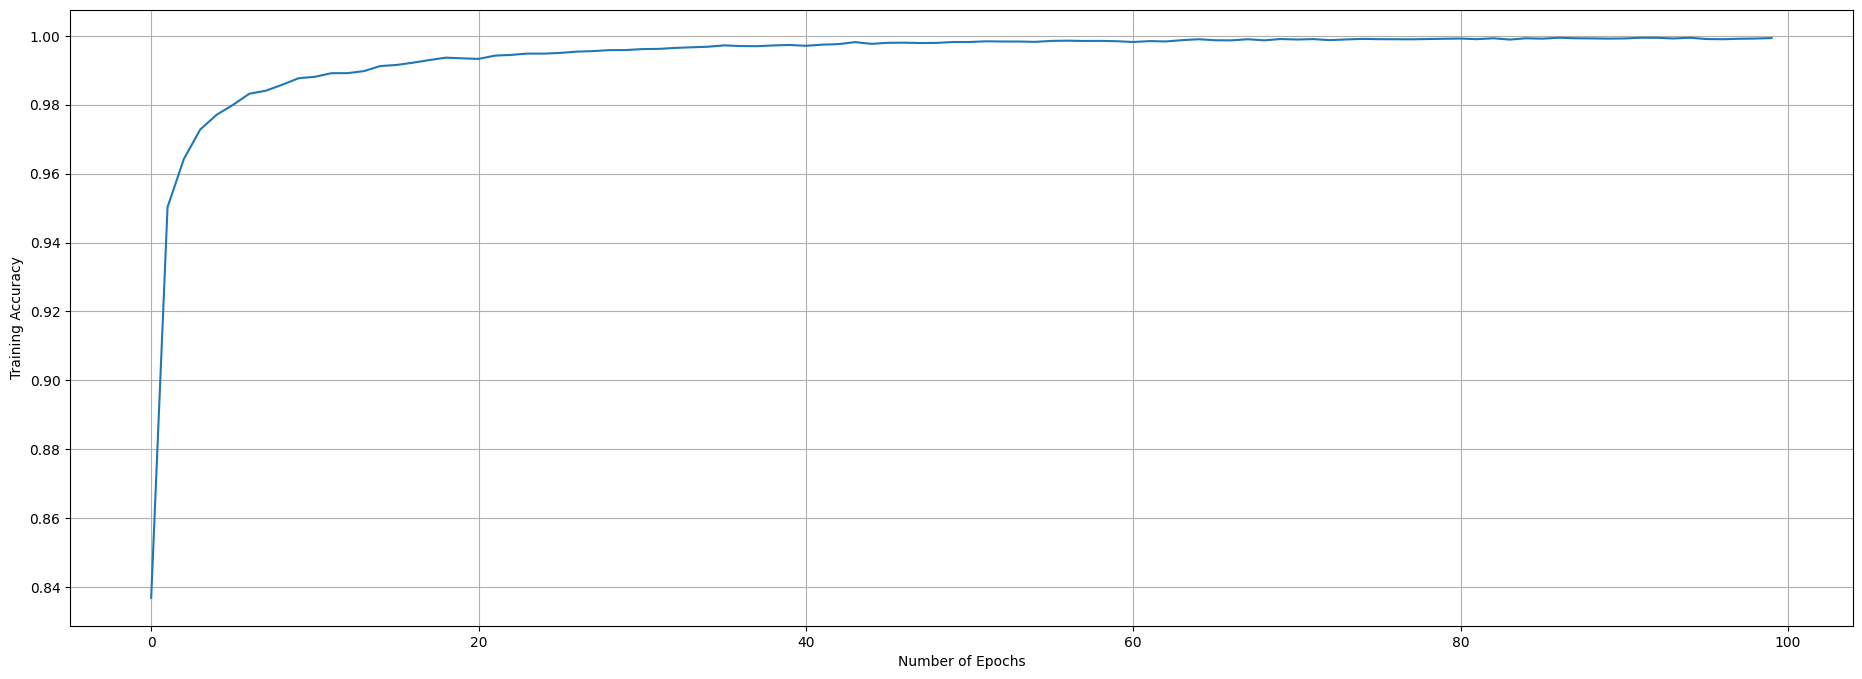

In [19]:
# The matplotlib package is used for plotting graphs
import matplotlib
import matplotlib.pyplot as plt
# Outputs training accuracy and loss against epochs
fig2, ax2=plt.subplots(figsize=(23,8))
ax2.plot(history.history['accuracy'])
ax2.set(xlabel='Number of Epochs', ylabel='Training Accuracy')
ax2.grid()
plt.show()